In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

%cd -q ../scripts/
from default_param import *

/usr/local/lib/python3.6/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


#  FLE


In this script the CONDENSATION is done for rightward and leftward motion of a dot stimulus, at different levels of noise. also for flashing stimuli needed for simulation of flash initiated and flash_terminated FLEs. 
The aim is to generate generate (Berry et al 99)'s figure 2: shifting RF position in the direction of motion.




## running the standard FLE


In [2]:
%%writefile experiment_fle.py
import MotionParticles as mp
gen_dot = mp.generate_dot
import numpy as np
import os
from default_param import *

image = {}
experiment = 'FLE'
do_sim = False
do_sim = True
for stimulus_tag, im_arg in zip(stim_labels, stim_args):
    # generating the movie
    image[stimulus_tag] = {}
    image[stimulus_tag]['args'] = im_arg
    image[stimulus_tag]['im'] = gen_dot(N_X=N_X, N_Y=N_Y, N_frame=N_frame, **image[stimulus_tag]['args'])
    mp.anim_save(image[stimulus_tag]['im'], os.path.join(mp.figpath, experiment + '-' + stimulus_tag + '-anim'))
    image[stimulus_tag]['result'] = {}
    if do_sim:
        # running PX and MBP with 2 different latencies
        for D_x, D_V, v_prior, label in zip([mp.D_x, PBP_D_x], [mp.D_V, PBP_D_V], [mp.v_prior, PBP_prior], ['MBP', 'PBP']):
            figname = os.path.join(mp.figpath, experiment + '-' + stimulus_tag + '-' + label)
            
            image[stimulus_tag]['result'][label] = {}
            image[stimulus_tag]['args'].update(D_V=D_V, D_x=D_x, v_prior=v_prior)
            _  = mp.figure_image_variable(
                    figname, 
                    N_X, N_Y, N_frame, gen_dot, order=None, 
                    do_figure=do_figure, do_video=do_video, N_quant_X=N_quant_X, N_quant_Y=N_quant_Y,
                    fixed_args=image[stimulus_tag]['args'], latency=latencies)
            try:
                for latency in latencies:
                    matname = mp.make_figname(figname, {'latency': latency}).replace(mp.figpath, mp.matpath) + '.npy'
                    image[stimulus_tag]['result'][label][latency] = np.load(matname)
            except:
                print('no result yet for ', matname)

Overwriting experiment_fle.py


In [3]:
%run experiment_fle.py

Sequence results/FLE-dot-anim.mp4 already exists (remove to recompute)
Studying CONDENSATION by changing image along variable(s) : {'latency': [0, 10]}
Studying CONDENSATION by changing image along variable(s) : {'latency': [0, 10]}
Sequence results/FLE-flash-anim.mp4 already exists (remove to recompute)
Studying CONDENSATION by changing image along variable(s) : {'latency': [0, 10]}
Studying CONDENSATION by changing image along variable(s) : {'latency': [0, 10]}


In [4]:
print (image[stimulus_tag]['result'].keys())
print (image[stimulus_tag]['result']['MBP'].keys())

dict_keys(['MBP', 'PBP'])
dict_keys([0, 10])


## x-t plot of the stimulation

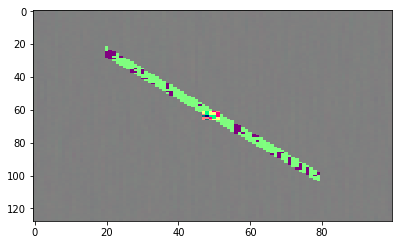

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/phi))
__temp = np.zeros((N_X, N_frame, 3))
for i, stimulus_tag in enumerate(['flash', 'dot']):
    __temp[:, :, i] = image[stimulus_tag]['im'][:, N_Y//2, :]
ax.imshow(.5*__temp+.5, interpolation='nearest',  aspect='auto', vmin=-1., vmax=1.)

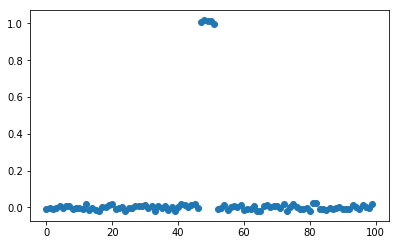

In [6]:
fig = plt.figure(figsize=(fig_width, fig_width /phi))
a = fig.add_subplot(1, 1, 1)
a.plot(image['flash']['im'][N_X//2, N_Y//2, :], 'o')


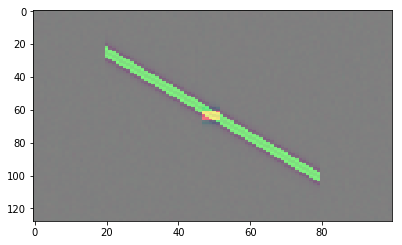

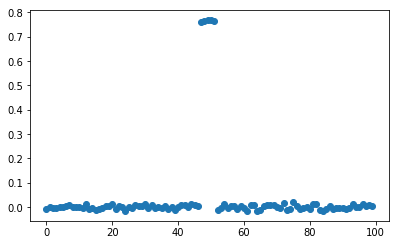

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width/phi))
__temp = np.zeros((N_X, N_frame, 3))
for i, stimulus_tag in enumerate(['flash', 'dot']):
    white = mp.whitening(image[stimulus_tag]['im'])
    white /= np.abs(white).max()
    __temp[:, :, i] = white[:, N_Y//2, :]
ax.imshow(.5*__temp+.5, interpolation='nearest',  aspect='auto', vmin=-1., vmax=1.)
fig = plt.figure(figsize=(fig_width, fig_width /phi))
a = fig.add_subplot(1, 1, 1)
a.plot(__temp[N_X//2, :, 0], 'o')


## x-t histograms of the results

First showing the histogram of detected positions for both stimuli:

In [8]:
v_hist = {}
time = np.linspace(0, 1, N_frame)
for i, stimulus_tag in enumerate(stim_labels):
    particles = image[stimulus_tag]['result']['MBP'][10].copy()
    v_hist[stimulus_tag], x_edges, y_edges = mp.spatial_readout(particles, N_quant_X=N_quant_Y, N_quant_Y=1, display=False)
    v_hist[stimulus_tag] /= np.sum(v_hist[stimulus_tag], axis=0)


In [9]:
_, x_edges, y_edges = mp.spatial_readout(particles, N_quant_X=N_quant_Y, N_quant_Y=N_quant_Y, display=False)
x_middle = .5*(x_edges[1:] + x_edges[:-1])
print('Position of the middle of the bins =', x_middle)
y_middle = .5*(y_edges[1:] + y_edges[:-1])

Position of the middle of the bins = [-0.98 -0.94 -0.9  -0.86 -0.82 -0.78 -0.74 -0.7  -0.66 -0.62 -0.58 -0.54
 -0.5  -0.46 -0.42 -0.38 -0.34 -0.3  -0.26 -0.22 -0.18 -0.14 -0.1  -0.06
 -0.02  0.02  0.06  0.1   0.14  0.18  0.22  0.26  0.3   0.34  0.38  0.42
  0.46  0.5   0.54  0.58  0.62  0.66  0.7   0.74  0.78  0.82  0.86  0.9
  0.94  0.98]


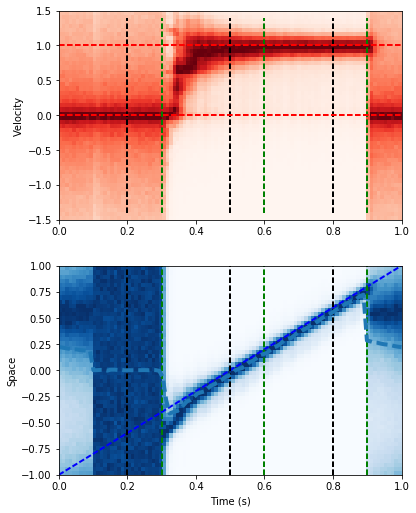

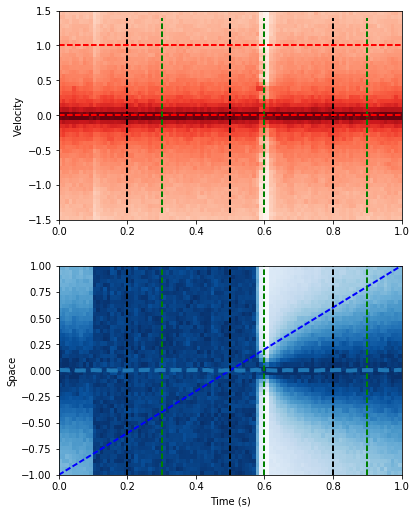

In [10]:
#fig, axs = plt.subplots(1, 2, figsize=(2*fig_width, fig_width /2))
for i, stimulus_tag in enumerate(stim_labels):
    particles = image[stimulus_tag]['result']['MBP'][10].copy()    
    fig, axs = mp.spatial_readout(particles, N_quant_X=N_quant_Y, N_quant_Y=1)#, fig=fig, a=axs[i])
    average_pos = np.sum(v_hist[stimulus_tag]*x_middle[:, np.newaxis], axis=0)
    axs[0].plot(time, average_pos, lw=4, ls='--')

## Find the maximum of position precision for the flash:

array([  5.0197e-03,   1.4901e-03,   1.2796e-03,  -1.4674e-03,
         4.5829e-03,  -2.1205e-03,  -2.5024e-03,  -7.8428e-04,
        -3.2531e-03,  -1.3742e-03,   2.6487e-03,  -1.8379e-04,
        -1.3128e-03,   1.6197e-03,   1.2423e-03,  -2.7201e-03,
        -1.3333e-03,  -2.4044e-03,  -1.1384e-05,  -2.5533e-03,
        -6.6197e-04,   5.4233e-04,  -6.0462e-04,   3.2887e-04,
         1.5631e-03,   1.5522e-03,   3.1771e-03,   2.2202e-04,
        -1.3512e-03,   2.3861e-03,   2.9082e-03,   1.0139e-03,
         2.6595e-03,   1.1202e-03,   3.5316e-03,   1.5134e-03,
         1.5923e-03,   2.0839e-04,   1.6837e-03,   1.6460e-03,
         2.3173e-03,  -5.6155e-04,   1.6004e-03,   2.7951e-03,
        -3.1234e-03,  -6.7324e-03,  -1.3913e-03,  -4.1944e-03,
         3.3469e-05,  -5.6569e-04,  -1.7753e-03,   1.4809e-03,
        -2.9002e-03,  -2.7250e-03,  -2.1421e-03,   3.2679e-04,
         4.6304e-04,   4.3026e-03,  -6.3717e-04,   2.7437e-03,
         1.8202e-03,  -2.4187e-04,  -1.9792e-03,  -2.85

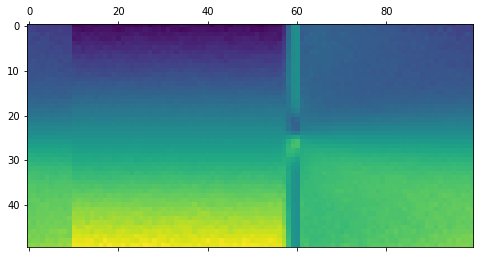

In [11]:
plt.matshow(v_hist['flash']*x_middle[:, np.newaxis])
average_pos = np.sum(v_hist[stimulus_tag]*x_middle[:, np.newaxis], axis=0)
average_pos

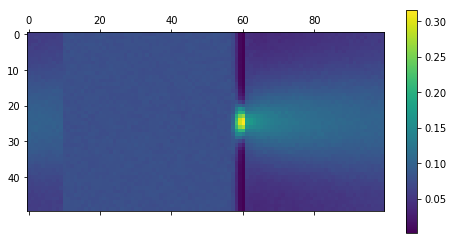

In [12]:
plt.matshow(-v_hist[stimulus_tag]*np.log(v_hist[stimulus_tag]))
plt.colorbar();

Flash occurs at frame  60


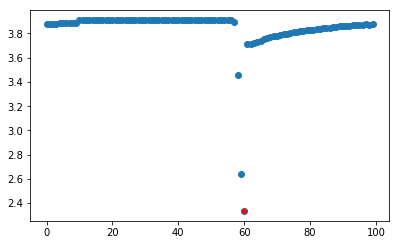

In [13]:
stimulus_tag = 'flash'
entropy = np.sum(-v_hist[stimulus_tag]*np.log(v_hist[stimulus_tag]), axis=0)
#print(average_std)
ind_min = np.argmin(entropy)
print('Flash occurs at frame ', ind_min)
fig = plt.figure(figsize=(fig_width, fig_width /phi))
a = fig.add_subplot(1, 1, 1)
a.plot(entropy, 'o')
_ = a.plot([ind_min], [entropy[ind_min]], 'r*')

Flash occurs at frame  60


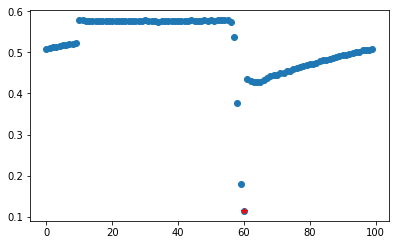

In [14]:
stimulus_tag = 'flash'
average_pos = np.sum(v_hist[stimulus_tag]*x_middle[:, np.newaxis], axis=0)
average_std = np.sqrt(np.sum(v_hist[stimulus_tag]*(x_middle[:, np.newaxis]-average_pos[np.newaxis, :])**2, axis=0))
time_ind_max_flash = np.argmin(average_std)
print('Flash occurs at frame ', ind_min)
    
fig = plt.figure(figsize=(fig_width, fig_width /phi))
a = fig.add_subplot(1, 1, 1)
a.plot(average_std, 'o')
_ = a.plot([time_ind_max_flash], [average_std[time_ind_max_flash]], 'r*')


Now showing the spatial histogram for both stimuli at this moment:

average_xpos_max 0.164165165104 average_ypos_max 0.000966112236383
average_xvar_max 0.00978125082927 average_yvar_max 0.00720061866353
average_xpos_max 0.00182019748546 average_ypos_max 0.000359693491873
average_xvar_max 0.0129002819986 average_yvar_max 0.0128422378855


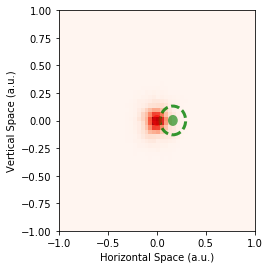

In [15]:
fig, axA = plt.subplots(1, 1, figsize=(fig_width/1.618, fig_width/1.618))
N_frame_av = 0
v_hist_max = np.zeros((N_quant_X, N_quant_Y, 3))
#time_ind_max_flash = 60
for i, (stimulus_tag, cmap, color) in enumerate(zip(stim_labels, [plt.cm.Greens, plt.cm.Reds], ['g', 'r'])):
    #if stimulus_tag == 'flash':
    #    average_pos = np.sum(v_hist[stimulus_tag]*x_middle[:, np.newaxis], axis=0)
    #    average_std = np.sum(v_hist[stimulus_tag]*(x_middle[:, np.newaxis]-average_pos[np.newaxis, :])**2, axis=0)
    #    time_ind_max_flash = np.argmin(average_std)
    particles = image[stimulus_tag]['result']['MBP'][10].copy() 
    for i_frame in  range(time_ind_max_flash-N_frame_av, time_ind_max_flash+N_frame_av+1):
        #print(i_frame)
        v_hist_max_av, x_edges, y_edges = mp.spatial_readout(particles[:, :, i_frame], 
                                                            N_quant_X=N_quant_Y, N_quant_Y=N_quant_Y, display=False)
        #v_hist_max_av /= np.sum(v_hist_max_av, axis=0)

        v_hist_max[:, :, i] += v_hist_max_av/(2*N_frame_av+1)

    #v_hist_max[:, :, i] -= v_hist_max[:, :, i].min() # HACK
    #a.pcolor(x_edges, y_edges, v_hist_max[:, :, 0], vmin=0., vmax=v_hist_max[:, :, 0].max(), cmap=plt.cm.winter, edgecolor='k', alpha=.3)
    c= axA.pcolormesh(x_edges, y_edges, v_hist_max[:, :, i].T, 
             vmin=0., vmax=v_hist_max[:, :, i].max(), cmap=cmap)#, edgecolor=(1, 1, 1, 1.), alpha=.8)#*i)#(1-i))
    c._is_stroked = False
    average_xpos_max = np.sum(v_hist_max[:, :, i].sum(axis=1)*x_middle, axis=0)
    average_xvar_max = np.sum(v_hist_max[:, :, i].sum(axis=1)*(x_middle[:]-average_xpos_max)**2, axis=0)
    average_ypos_max = np.sum(v_hist_max[:, :, i].sum(axis=0)*y_middle, axis=0)
    average_yvar_max = np.sum(v_hist_max[:, :, i].sum(axis=0)*(y_middle[:]-average_ypos_max)**2, axis=0)
    print('average_xpos_max', average_xpos_max, 'average_ypos_max', average_ypos_max)
    print('average_xvar_max', average_xvar_max, 'average_yvar_max', average_yvar_max)
    circle = axA.add_artist(plt.Circle((average_xpos_max, average_ypos_max), 
                                     dot_size, #np.sqrt(average_xstd_max+average_ystd_max)/20,
                                     alpha=.6, facecolor=color, linewidth=3))
    if stimulus_tag == 'dot':    
        circle = axA.add_artist(plt.Circle((average_xpos_max, average_ypos_max), 
                                     np.sqrt(average_xvar_max+average_yvar_max),
                                     alpha=.8, facecolor='none', edgecolor=color, linewidth=3, linestyle='--'))

axA.set_xlabel('Horizontal Space (a.u.)')
axA.set_ylabel('Vertical Space (a.u.)')
#axA.set_ylabel('Probability')
_ = axA.axis([-mp.width/2, mp.width/2, -mp.width/2, mp.width/2])
plt.tight_layout()
 
for ext in FORMATS: fig.savefig(os.path.join('../figures/', 'FLE-A' + ext))

## panel temporal evolution

['dot', 'flash']


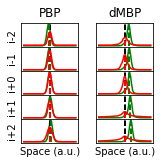

In [16]:
N_frame_av = 2
fig, axs = plt.subplots(2*N_frame_av+1, 2, figsize=(fig_width/2.618, fig_width/2.618))
for ax in axs.ravel(): 
    ax.axis(c='b', lw=2, axisbg='w')
    ax.set_facecolor('w')
print (stim_labels)
for j, (label, dlabel) in enumerate(zip(['PBP', 'MBP'], ['PBP', 'dMBP'])):
    for k, (stimulus_tag, cmap, color) in enumerate(zip(stim_labels, [plt.cm.Greens, plt.cm.Reds], ['g', 'r'])):
        particles = image[stimulus_tag]['result'][label][10].copy()
        v_hist[stimulus_tag], x_edges, y_edges = mp.spatial_readout(particles, N_quant_X=N_quant_Y, N_quant_Y=1, display=False)
        v_hist[stimulus_tag] /= np.sum(v_hist[stimulus_tag], axis=0)
        if stimulus_tag == 'flash':
            average_pos = np.sum(v_hist[stimulus_tag]*x_middle[:, np.newaxis], axis=0)
            average_std = np.sum(v_hist[stimulus_tag]*(x_middle[:, np.newaxis]-average_pos[np.newaxis, :])**2, axis=0)
            time_ind_max_flash = np.argmin(average_std)
            #print(ind_max_flash)
            pos_mean_flash = average_pos[time_ind_max_flash]

    for k, (stimulus_tag, cmap, color) in enumerate(zip(stim_labels, [plt.cm.Greens, plt.cm.Reds], ['g', 'r'])):
        particles = image[stimulus_tag]['result'][label][10]    
        for i, i_frame in  enumerate(range(time_ind_max_flash-N_frame_av, time_ind_max_flash+N_frame_av+1)):
            v_hist_, x_edges, y_edges = mp.spatial_readout(particles[:, :, i_frame], 
                                                                N_quant_X=N_quant_X, N_quant_Y=1, display=False)
            axs[i][j].plot(x_middle, v_hist_, c=color)#, alpha=.2+.8*(i_frame-ind_max_flash)/(2*N_frame_av+1))
            axs[i][j].plot([pos_mean_flash, pos_mean_flash], [0, v_hist_.max()], ls='--', lw=2, c='k')
            average_pos_ = np.sum(v_hist[stimulus_tag]*x_middle[:, np.newaxis], axis=0)

            axs[i][j].plot([average_pos_[i_frame], average_pos_[i_frame]], [0, v_hist_.max()], ls='--', lw=2, c=color)
            if i < time_ind_max_flash+N_frame_av:
                plt.setp(axs[i][j], xticks=[], yticks=[])
            axs[i][0].set_ylabel('i{:+d}'.format(i_frame-time_ind_max_flash))

        axs[2][0].plot([0], [0], lw=2, c=color, label=stimulus_tag)
        #if j is 0: axs[2][0].legend()
    axs[0][j].set_title(dlabel)
    axs[i][j].set_xlabel('Space (a.u.)')
plt.tight_layout()
fig.subplots_adjust(hspace = .01)
for ext in FORMATS: fig.savefig(os.path.join('../figures/', 'FLE-B' + ext))

## panel for speed

In [17]:
speeds = np.linspace(3.75, 1., 11, endpoint=True)
speeds

array([ 3.75 ,  3.475,  3.2  ,  2.925,  2.65 ,  2.375,  2.1  ,  1.825,
        1.55 ,  1.275,  1.   ])

In [18]:
%%writefile experiment_speed.py

import MotionParticles as mp
gen_dot = mp.generate_dot
import numpy as np
import os
from default_param import *

image_speed = {}
experiment = 'speed'

speeds = np.linspace(3.75, 1., 11, endpoint=True)
# make such that the dot crosses the middle of the screen at t=.5 while making the same distance
X_0s = -speeds
dot_starts = .5 - .4 / speeds
flash_durations = .8 / speeds

stimulus_tag = stim_labels[0] # 'dot'
im_arg = stim_args[0]

# generating the movie
image_speed[stimulus_tag] = {}
image_speed[stimulus_tag]['args'] = {'Y_0':0,  'im_noise':mp.im_noise,  'dot_size':dot_size}
image_speed[stimulus_tag]['im'] = gen_dot(N_X=N_X, N_Y=N_Y, N_frame=N_frame, **image_speed[stimulus_tag]['args'])

image_speed[stimulus_tag]['result'] = {}
# running PX and MBP with 2 different latencies
for D_x, D_V, v_prior, label in zip([mp.D_x, PBP_D_x], [mp.D_V, PBP_D_V], [mp.v_prior, PBP_prior], ['MBP', 'PBP']):
    figname = os.path.join(mp.figpath, experiment + '-' + stimulus_tag + '-' + label)

    image_speed[stimulus_tag]['result'][label] = {}
    image_speed[stimulus_tag]['args'].update(D_V=D_V, D_x=D_x, v_prior=v_prior)

    kwargs_variable  = mp.figure_image_variable(
            figname, 
            N_X, N_Y, N_frame, gen_dot, order=None, do_figure=do_figure, do_video=do_video, N_quant_X=N_quant_X, N_quant_Y=N_quant_Y,
            fixed_args=image_speed[stimulus_tag]['args'],
            V_X=speeds, X_0=X_0s, flash_start=dot_starts, flash_duration=flash_durations)

    for new_kwargs in kwargs_variable:
        try:
            matname = mp.make_figname(figname, new_kwargs).replace(mp.figpath, mp.matpath) + '.npy'
            image_speed[stimulus_tag]['result'][label][new_kwargs['V_X']] = np.load(matname)
        except:
            print('no result yet for ', matname)


Overwriting experiment_speed.py


In [19]:
%run experiment_speed.py

Studying CONDENSATION by changing image along variable(s) : {'V_X': array([ 3.75 ,  3.475,  3.2  ,  2.925,  2.65 ,  2.375,  2.1  ,  1.825,
        1.55 ,  1.275,  1.   ]), 'X_0': array([-3.75 , -3.475, -3.2  , -2.925, -2.65 , -2.375, -2.1  , -1.825,
       -1.55 , -1.275, -1.   ]), 'flash_start': array([ 0.3933,  0.3849,  0.375 ,  0.3632,  0.3491,  0.3316,  0.3095,
        0.2808,  0.2419,  0.1863,  0.1   ]), 'flash_duration': array([ 0.2133,  0.2302,  0.25  ,  0.2735,  0.3019,  0.3368,  0.381 ,
        0.4384,  0.5161,  0.6275,  0.8   ])}
Studying CONDENSATION by changing image along variable(s) : {'V_X': array([ 3.75 ,  3.475,  3.2  ,  2.925,  2.65 ,  2.375,  2.1  ,  1.825,
        1.55 ,  1.275,  1.   ]), 'X_0': array([-3.75 , -3.475, -3.2  , -2.925, -2.65 , -2.375, -2.1  , -1.825,
       -1.55 , -1.275, -1.   ]), 'flash_start': array([ 0.3933,  0.3849,  0.375 ,  0.3632,  0.3491,  0.3316,  0.3095,
        0.2808,  0.2419,  0.1863,  0.1   ]), 'flash_duration': array([ 0.2133,  0.2302

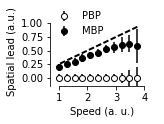

In [20]:
#time_ind_max_flash = 60

fig, axC = plt.subplots(1, 1, figsize=(fig_width/2.618, fig_width/3.618))
axC.axis(c='b', lw=2, axisbg='w')
axC.set_facecolor('w')
#print(time_ind_max_flash)
v_hist_max = np.zeros((N_quant_X, N_quant_Y, 3))
for i, (label, color) in enumerate(zip(['PBP', 'MBP'], ['w', 'k'])):
#for i, (label, color) in enumerate(zip(['MBP'], [ 'g'])):
    stimulus_tag = stim_labels[0] # 'dot'
    #print(stimulus_tag, x_middle)
    spatial_lead = np.zeros((len(speeds), mp.N_trials, 2*N_frame_av+1))
    spatial_lead_std = np.zeros((len(speeds), mp.N_trials, 2*N_frame_av+1))
    for i_V, V_X in enumerate(speeds):
        #dot_pos = np.zeros(mp.N_trials)
        for i_trial in range(mp.N_trials):
            particles = image_speed[stimulus_tag]['result'][label][V_X][:, (i_trial*mp.N_particles):((i_trial+1)*mp.N_particles), :].copy()
            for i, i_frame in  enumerate(range(time_ind_max_flash-N_frame_av, time_ind_max_flash+N_frame_av+1)):
                v_hist_, x_edges, y_edges = mp.spatial_readout(particles[:, :, i_frame], N_quant_X=N_quant_Y, N_quant_Y=1, display=False)
                v_hist_ /= np.sum(v_hist_)
                v_hist_ = v_hist_.ravel()
                x_middle = .5*(x_edges[1:] + x_edges[:-1])
                spatial_lead[i_V, i_trial, i] = np.sum(v_hist_*x_middle)
                spatial_lead_std[i_V, i_trial, i] = np.sqrt(np.sum(v_hist_*(x_middle-spatial_lead[i_V, i_trial, i])**2))

            #print (v_hist_.min(), v_hist_.max(), v_hist_.shape, V_X, average_pos)
            #dot_pos += x_middle[np.argmax(v_hist_)] / (2*N_frame_av+1)

        #spatial_lead[i_V, i_trial] = dot_pos
    
    #axC.errorbar(speeds, spatial_lead.mean(axis=1), yerr=spatial_lead.std(axis=1), c=color, fmt='o', ecolor='k')
    axC.errorbar(speeds, spatial_lead.mean(axis=(1, 2)), yerr=spatial_lead_std.mean(axis=(1, 2)), 
                 marker='o', c='k', markerfacecolor=color, fmt='o', ecolor='k', label=label)
    #axC.plot(speeds, spatial_lead.mean(axis=1), 'o', c=color)

slope = .25 # TODO: fix to rather 2 units * 100ms / 1s
axC.plot(speeds, speeds*slope, c='k', lw=2, ls='--')
axC.set_xlabel('Speed (a. u.)')
axC.set_ylabel('Spatial lead (a.u.)')
axC.set_xlim((0.7, speeds.max()*1.15))
axC.set_ylim((-0.15, 1.1))
axC.legend(loc='best', bbox_to_anchor=(0., .6, .6, .1), 
           ncol=1, frameon=False)
axC.spines['top'].set_color('none')
axC.spines['right'].set_color('none')
axC.spines['left'].set_smart_bounds(True)
axC.spines['bottom'].set_smart_bounds(True)
axC.xaxis.set_ticks_position('bottom')
axC.yaxis.set_ticks_position('left')
plt.locator_params(axis = 'x', nbins = 5)
plt.locator_params(axis = 'y', nbins = 5)
plt.tight_layout()
for ext in FORMATS: fig.savefig(os.path.join('../figures/', 'FLE-C' + ext))

## Montage of the subplots

In [21]:
import tikzmagic

In [22]:
!ls -l ../figures/FLE.* ../figures/FLE-*

-rw-r--r--  1 lolo  staff    73357 Feb 20 15:24 ../figures/FLE-A.pdf
-rw-r--r--  1 lolo  staff    11320 Feb 20 15:24 ../figures/FLE-A.png
-rw-r--r--  1 lolo  staff    17038 Feb 20 15:25 ../figures/FLE-B.pdf
-rw-r--r--  1 lolo  staff    11334 Feb 20 15:25 ../figures/FLE-B.png
-rw-r--r--  1 lolo  staff    11667 Feb 20 15:38 ../figures/FLE-C.pdf
-rw-r--r--  1 lolo  staff     7397 Feb 20 15:38 ../figures/FLE-C.png
-rw-r--r--  1 lolo  staff   172068 Jan 23 16:59 ../figures/FLE.jpg
-rw-r--r--  1 lolo  staff    95760 Jan 23 16:59 ../figures/FLE.pdf
-rw-r--r--  1 lolo  staff  1807716 Jan 23 17:00 ../figures/FLE.tiff


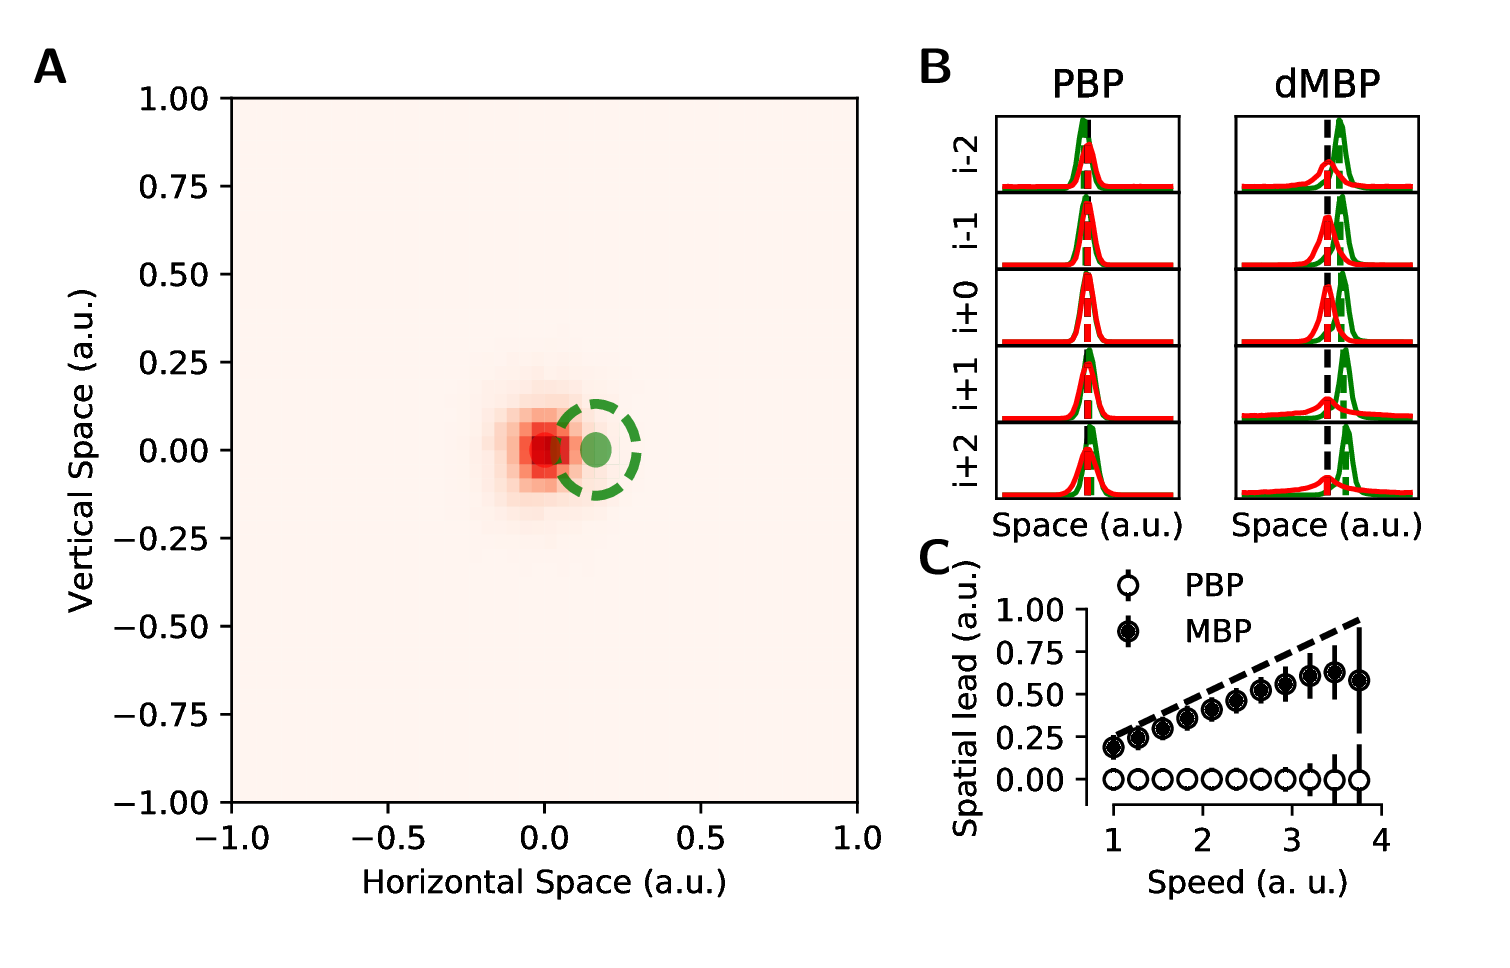

In [23]:
%%tikz -e ../figures/FLE.pdf
\draw[white, fill=white] (0.\textwidth,0) rectangle (1.03\textwidth, .65\textwidth) ;
\draw [anchor=south west] (0, 0) node {\includegraphics[width=.618\textwidth]{../figures/FLE-A.pdf}};
\draw [anchor=south west] (.618\textwidth, .25\textwidth) node {\includegraphics[width=.382\textwidth]{../figures/FLE-B.pdf}};
\draw [anchor=south west] (.618\textwidth, 0) node {\includegraphics[width=.375\textwidth]{../figures/FLE-C.pdf}};
\begin{scope}[font=\bf\sffamily\large]
\draw [anchor=west,fill=white] (0, .618\textwidth) node {A};
\draw [anchor=west,fill=white] (.618\textwidth, .618\textwidth) node {B};
\draw [anchor=west,fill=white] (.618\textwidth, .275\textwidth) node {C};
\end{scope}

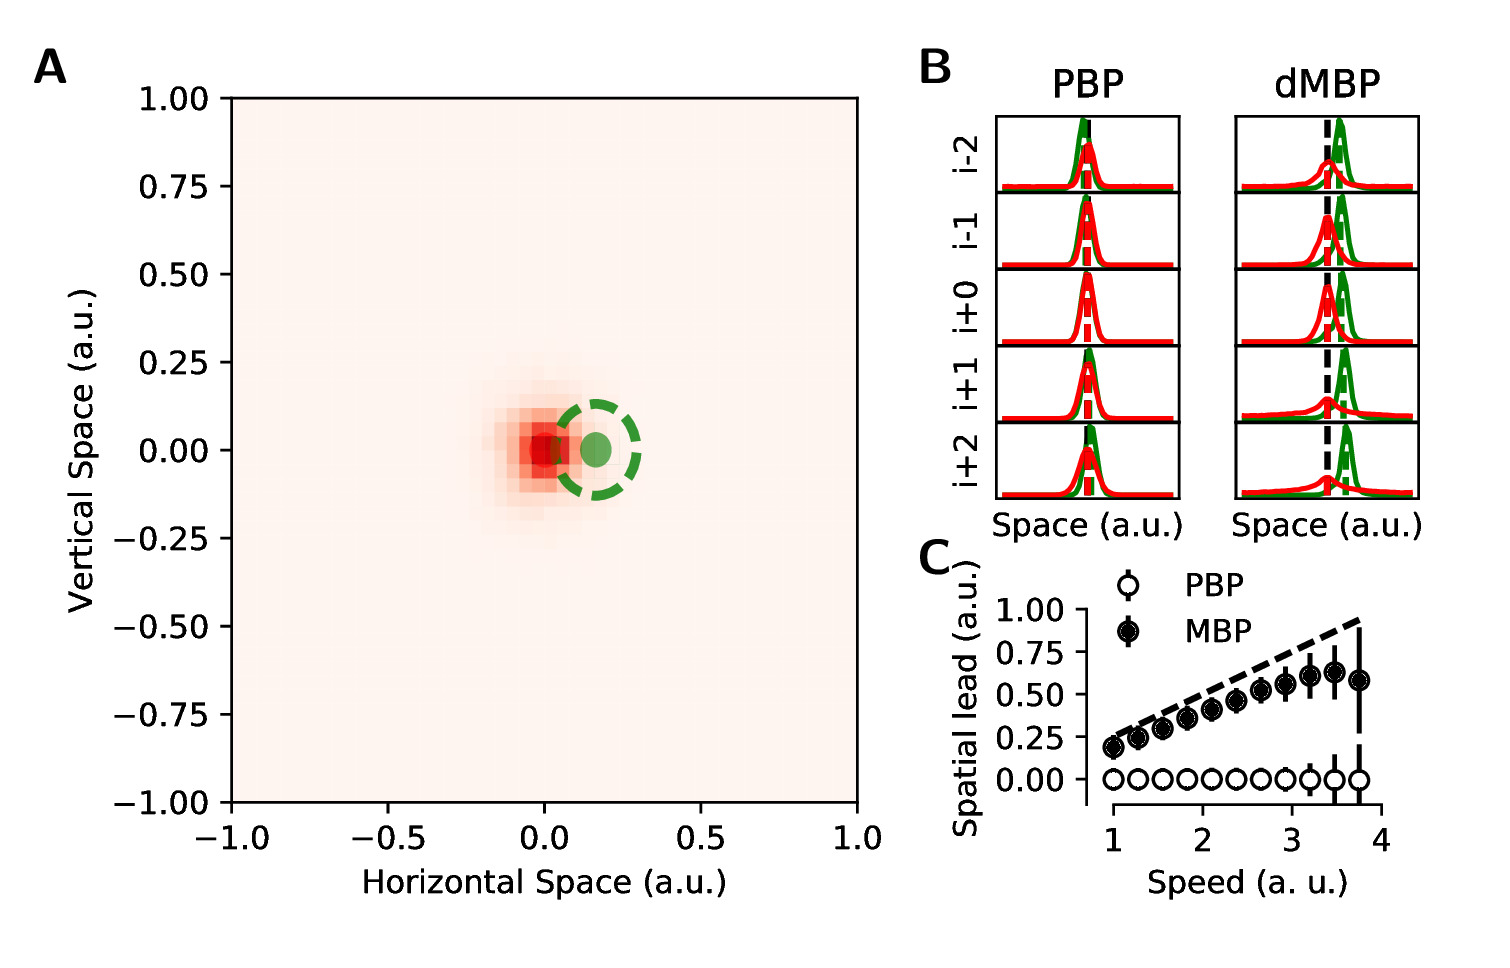

In [24]:
!convert  -density 300 ../figures/FLE.pdf ../figures/FLE.jpg
!convert  -density 600 -resize 5400  -units pixelsperinch -flatten  -compress lzw  -depth 8 ../figures/FLE.pdf ../figures/FLE.tiff

from IPython.display import SVG, Image
Image('../figures/FLE.jpg')

In [25]:
!echo "width=" ; convert ../figures/FLE.tiff -format "%[fx:w]" info:
!echo ", \nheight=" ; convert ../figures/FLE.tiff -format "%[fx:h]" info:
!echo ", \nunit=" ; convert ../figures/FLE.tiff -format "%U" info:

width=
5400, 
height=
3462, 
unit=
PixelsPerInch

In [26]:
!identify ../figures/FLE.tiff 

../figures/FLE.tiff TIFF 5400x3462 5400x3462+0+0 8-bit sRGB 1.815MB 0.000u 0:00.000


## version control

In [27]:
!git pull
#!git add ../figures/*mp4
#!git add ../figures/FLE-A* ../figures/FLE-B* ../figures/FLE-C*
!git status

error: Your local changes to the following files would be overwritten by merge:
	scripts/default_param.py
Please commit your changes or stash them before you merge.
Aborting
On branch master
Your branch and 'origin/master' have diverged,
and have 8 and 1 different commits each, respectively.
  (use "git pull" to merge the remote branch into yours)
Changes to be committed:
  (use "git reset HEAD <file>..." to unstage)

	new file:   default_param.py
	new file:   experiment_SI_controls.py
	new file:   experiment_contrast.py
	new file:   experiment_fle.py
	new file:   experiment_speed.py

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git checkout -- <file>..." to discard changes in working directory)

	modified:   ../.gitignore
	modified:   ../figures/FLE-A.pdf
	modified:   ../figures/FLE-A.png
	modified:   ../figures/FLE-B.pdf
	modified:   ../figures/FLE-B.png
	modified:   ../figures/FLE-C.pdf
	modified:   ../figures/FLE-C.png
	modifie

In [28]:
!git commit -m' figure FLE : relaunching nb '  ../khoei17fle.tex ../notebooks/figure_3_FLE.ipynb experiment_speed.py experiment_fle.py  ../figures/FLE.* ../figures/FLE-A* ../figures/FLE-B* ../figures/FLE-C*
!#git push

[master 707ca96]  figure FLE : relaunching nb
 12 files changed, 1451 insertions(+), 1383 deletions(-)
 rewrite figures/FLE-A.pdf (85%)
 rewrite figures/FLE-A.png (99%)
 rewrite figures/FLE-B.png (99%)
 rewrite figures/FLE-C.png (97%)
 rewrite figures/FLE.jpg (91%)
 rewrite figures/FLE.pdf (78%)
 rewrite figures/FLE.tiff (77%)
 rewrite notebooks/figure_3_FLE.ipynb (89%)
 create mode 100644 scripts/experiment_fle.py
 create mode 100644 scripts/experiment_speed.py
